# Approximate $\tau_0$ and scale the burst drift

$ \tau_0 \simeq \frac{b}{\cos\theta} $ Where $b$ is the minor axis of the gaussian fit to the burst autocorrelation.
Then, if $d\nu_{\text{obs}} / dt_{\text{obs}}$ is the burst drift, we expect 


### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}}=\frac{\nu_{\text{obs}}^{2}}{\nu_{0}\tau_{0}}\simeq\frac{\nu_{\text{obs}}^{2}b}{\nu_{0}\cos\theta}$

In [232]:
import numpy as np
import scipy.stats
import scipy.odr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from tqdm import tqdm
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd

bursts121102 = pd.read_csv('../bursts.csv')
bursts121102 = bursts121102.set_index('name')

##########
bursts180916 = pd.merge(pd.read_csv('data/CHIME_180916.J0158+65/chime_180916_fit_params_ddm0.csv'),
                        pd.read_csv('data/CHIME_180916.J0158+65/chime_180916_param_errors_ddm0.csv'),
                        how='left', on='name')
bursts180916 = bursts180916.set_index('name')
bursts180916['time_res'] = 0.00098304 # s

#########
params180916 = ['data/CHIME_180916.J0158+65/chime_180916_fit_params_ddm0.csv',
               'data/CHIME_180916.J0158+65/chime_180916_fit_params_ddm-1.csv',
               'data/CHIME_180916.J0158+65/chime_180916_fit_params_ddm-2.csv',
               'data/CHIME_180916.J0158+65/chime_180916_fit_params_ddm0.5.csv']

paramerrs180916 = ['data/CHIME_180916.J0158+65/chime_180916_param_errors_ddm0.csv',
                   'data/CHIME_180916.J0158+65/chime_180916_param_errors_ddm-1.csv',
                   'data/CHIME_180916.J0158+65/chime_180916_param_errors_ddm-2.csv',
                   'data/CHIME_180916.J0158+65/chime_180916_param_errors_ddm0.5.csv']

dataframes180916 = []
for param, paramerr in zip(params180916, paramerrs180916):
    frame = pd.merge(pd.read_csv(param),
                     pd.read_csv(paramerr),
                     how='left', on='name')
    frame = frame.set_index('name')
    frame['time_res'] = 0.00098304 # s
    dataframes180916.append(frame)

#########

#########
dms180814 = [189.0 , 189.8 , 190.0, 188.9 , 189.4, 188.8, 188.7]
dm_idx = 3
bursts180814 = pd.merge(pd.read_csv('data/CHIME_FRB180814.J0422+73/chime_180814_fit_params_dm{}.csv'.format(dms180814[dm_idx])),
                        pd.read_csv('data/CHIME_FRB180814.J0422+73/chime_180814_param_errors_dm{}.csv'.format(dms180814[dm_idx])),
                        how='left', on='name')
bursts180814 = bursts180814.set_index('name')
bursts180814['time_res'] = 0.00098304 # s, Not true for burst 180917

dataframes180814 = []
for dm in dms180814:
    frame = pd.merge(pd.read_csv('data/CHIME_FRB180814.J0422+73/chime_180814_fit_params_dm{}.csv'.format(dm)),
                            pd.read_csv('data/CHIME_FRB180814.J0422+73/chime_180814_param_errors_dm{}.csv'.format(dm)),
                            how='left', on='name')
    frame = frame.set_index('name')
    frame['time_res'] = 0.00098304 # s, Not true for burst 180917
    dataframes180814.append(frame)

# Correct sigmax and sigmay for pixel scale
# bursts180814['sigmax'] = bursts180814[['sigmaxp', 'xscale']].apply(lambda row: abs(row['sigmaxp'])/row['xscale'], axis=1)
# bursts180814['sigmay'] = bursts180814[['sigmayp', 'yscale']].apply(lambda row: abs(row['sigmayp'])/row['yscale'], axis=1)
# bursts180814['sigmax_error'] = bursts180814[['sigmaxp_error', 'xscale']].apply(lambda row: abs(row['sigmaxp_error'])/row['xscale'], axis=1)
# bursts180814['sigmay_error'] = bursts180814[['sigmayp_error', 'yscale']].apply(lambda row: abs(row['sigmayp_error'])/row['yscale'], axis=1)

# Set redshifts
bursts121102['z'] = 0.19273 # (josephy et al. 2019, frbcat.org)
bursts180916['z'] = 0.0337  # (chime 2020b et al.)
bursts180814['z'] = 0.05    # not accurate, z < 0.1 (amiri et al. 2019)
for frame in dataframes180916:
    frame['z'] = 0.337
for frame in dataframes180814:
    frame['z'] = 0.05

# bursts121102
bursts180916

,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle,center_f,amp_error,xo_error,yo_error,sigmax_error,sigmay_error,angle_error,drift error (mhz/ms),red_chisq,time_res,z
name,,,,,,,,,,,,,,,,,,,
13.0,200.000000,80.407968,64.005301,14.931826,1.688729,1.789540,-28.600117,1.789540,694.359833,8.162111,0.148366,0.595043,0.609376,0.068918,0.006612,0.892690,0.743294,0.000983,0.0337
14.0,652.605148,80.362354,64.339470,2.630949,8.604297,0.609741,-9.101675,-0.961055,513.724573,12.832853,0.105767,0.141834,0.051735,0.169195,0.009380,0.181860,0.452591,0.000983,0.0337
15.0,95.938058,140.409694,64.352958,12.106750,5.645504,2.062480,-11.871520,2.062480,649.122617,0.673026,0.053167,0.077170,0.084931,0.039604,0.005912,0.168631,2.755384,0.000983,0.0337
15.5,527.529669,176.365099,64.243880,3.039805,8.197538,0.506631,-11.456694,-1.064165,494.136508,5.769830,0.052325,0.080040,0.033248,0.089660,0.006650,0.179574,2.190109,0.000983,0.0337
16.0,471.367870,80.277935,64.090880,2.125115,4.835542,0.287827,-21.475653,-1.282969,497.038997,13.110688,0.068337,0.130051,0.059108,0.134496,0.021425,1.690406,0.614140,0.000983,0.0337
18.0,2712.600356,80.460995,64.335280,14.449545,3.211479,1.942930,-16.288749,1.942930,622.446260,35.544413,0.079226,0.177046,0.189344,0.042082,0.004333,0.208356,0.094759,0.000983,0.0337
19.0,1259.746447,80.379281,64.297830,8.573349,-2.708255,2.169715,-9.314804,2.169715,534.272500,24.116838,0.101968,0.138677,0.164135,0.051850,0.009501,0.190066,0.436231,0.000983,0.0337
21.0,315.111128,80.294710,64.265043,8.833778,3.815343,-0.987329,-9.631106,-0.987329,703.912708,7.098947,0.131003,0.172664,0.198969,0.085941,0.016916,0.354344,0.514910,0.000983,0.0337
23.0,4302.701500,80.481257,64.129712,13.979072,2.061264,1.814525,-25.567108,1.814525,552.540465,55.082906,0.050209,0.173789,0.178961,0.026388,0.002729,0.297920,0.045614,0.000983,0.0337


## Compute 121102 details

Text(0.5, 0, 'Burst #')

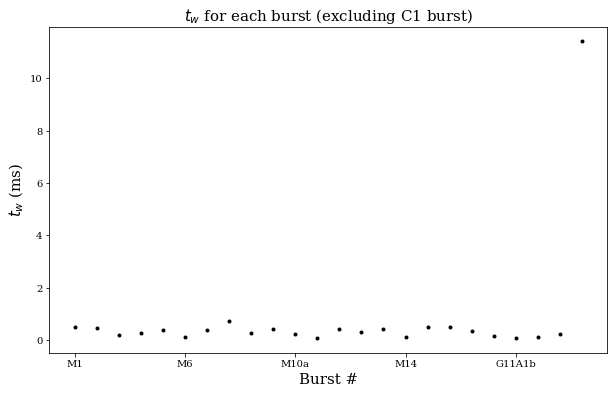

In [233]:
bursts121102['drift_abs'] = abs(bursts121102['drift (mhz/ms)'])
bursts121102['drift_over_nuobs'] = bursts121102[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts121102['min_sigma'] = bursts121102[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts121102['max_sigma'] = bursts121102[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)

# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts121102['min_sigma_error'] = bursts121102[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts121102['max_sigma_error'] = bursts121102[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts121102['sigma_t']   = bursts121102[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts121102['tau_w'] = bursts121102[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts121102['tau_w_error'] = bursts121102[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts121102['sigma_t_ms'] = bursts121102['sigma_t']*1e3
bursts121102['tau_w_ms'] = bursts121102['tau_w']*1e3

## C1 
bursts121102.at['C1', 'tau_w_ms'] = 11.4
bursts121102.at['C1', 'tau_w'] = 11.4/1000
bursts121102.at['C1', 'tau_w_error'] = 0.12

## Redshift corrections
bursts121102['drift_z'] = bursts121102[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts121102['tau_w_ms_z'] = bursts121102[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)

bursts121102_to_include = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9a', 'M9b', 'M10a', 'M10b', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'G11D', 'G11A1a', 'G11A1b', 'G11A2', 'G11A3', 'C1']
fontsize=15

selectbursts121102 = bursts121102.loc[bursts121102_to_include]
ax = selectbursts121102['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ for each burst (excluding C1 burst)", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')

## Compute 180916 details

Text(0.5, 0, 'Burst #')

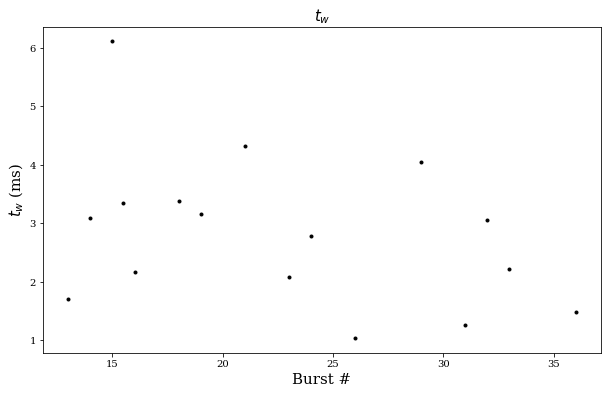

In [234]:
bursts180916['drift_abs'] = abs(bursts180916['drift (mhz/ms)'])
bursts180916['drift_over_nuobs'] = bursts180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts180916['min_sigma'] = bursts180916[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts180916['max_sigma'] = bursts180916[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts180916['min_sigma_error'] = bursts180916[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts180916['max_sigma_error'] = bursts180916[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts180916['sigma_t']   = bursts180916[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts180916['tau_w'] = bursts180916[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts180916['tau_w_error'] = bursts180916[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts180916['sigma_t_ms'] = bursts180916['sigma_t']*1e3
bursts180916['tau_w_ms'] = bursts180916['tau_w']*1e3

## Redshift corrections
bursts180916['drift_z'] = bursts180916[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts180916['tau_w_ms_z'] = bursts180916[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)

fontsize=15

selectbursts180916 = bursts180916
# selectbursts180916 = bursts180916.loc[[x for x in bursts180916.index if x not in [13, 32, 33, 36]]]
ax = selectbursts180916['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ ", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')
# selectbursts180916[['tau_w_ms', 'tau_w_error']]

## Compute 180916 Trial DM details

In [235]:
dataframes180916[0]

,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle,center_f,amp_error,xo_error,yo_error,sigmax_error,sigmay_error,angle_error,drift error (mhz/ms),red_chisq,time_res,z
name,,,,,,,,,,,,,,,,,,,
13.0,200.000000,80.407968,64.005301,14.931826,1.688729,1.789540,-28.600117,1.789540,694.359833,8.162111,0.148366,0.595043,0.609376,0.068918,0.006612,0.892690,0.743294,0.000983,0.337
14.0,652.605148,80.362354,64.339470,2.630949,8.604297,0.609741,-9.101675,-0.961055,513.724573,12.832853,0.105767,0.141834,0.051735,0.169195,0.009380,0.181860,0.452591,0.000983,0.337
15.0,95.938058,140.409694,64.352958,12.106750,5.645504,2.062480,-11.871520,2.062480,649.122617,0.673026,0.053167,0.077170,0.084931,0.039604,0.005912,0.168631,2.755384,0.000983,0.337
15.5,527.529669,176.365099,64.243880,3.039805,8.197538,0.506631,-11.456694,-1.064165,494.136508,5.769830,0.052325,0.080040,0.033248,0.089660,0.006650,0.179574,2.190109,0.000983,0.337
16.0,471.367870,80.277935,64.090880,2.125115,4.835542,0.287827,-21.475653,-1.282969,497.038997,13.110688,0.068337,0.130051,0.059108,0.134496,0.021425,1.690406,0.614140,0.000983,0.337
18.0,2712.600356,80.460995,64.335280,14.449545,3.211479,1.942930,-16.288749,1.942930,622.446260,35.544413,0.079226,0.177046,0.189344,0.042082,0.004333,0.208356,0.094759,0.000983,0.337
19.0,1259.746447,80.379281,64.297830,8.573349,-2.708255,2.169715,-9.314804,2.169715,534.272500,24.116838,0.101968,0.138677,0.164135,0.051850,0.009501,0.190066,0.436231,0.000983,0.337
21.0,315.111128,80.294710,64.265043,8.833778,3.815343,-0.987329,-9.631106,-0.987329,703.912708,7.098947,0.131003,0.172664,0.198969,0.085941,0.016916,0.354344,0.514910,0.000983,0.337
23.0,4302.701500,80.481257,64.129712,13.979072,2.061264,1.814525,-25.567108,1.814525,552.540465,55.082906,0.050209,0.173789,0.178961,0.026388,0.002729,0.297920,0.045614,0.000983,0.337


In [236]:
dataframes180916[0]['angle_error']

name
13.0    0.006612
14.0    0.009380
15.0    0.005912
15.5    0.006650
16.0    0.021425
18.0    0.004333
19.0    0.009501
21.0    0.016916
23.0    0.002729
24.0    0.040605
26.0    0.006139
29.0    0.019648
31.0    0.005930
32.0    0.009428
33.0    0.016887
36.0    0.002037
Name: angle_error, dtype: float64

In [237]:
# ddm = -1/2, 0, 1, 2
for idx in dataframes180916[0].index:
    print(idx, dataframes180916[3]['angle'].loc[idx],  dataframes180916[0]['angle'].loc[idx], dataframes180916[1]['angle'].loc[idx], dataframes180916[2]['angle'].loc[idx])

13.0 1.6946957502538031 1.789540147774537 1.9253075248386704 2.0647276306303506
14.0 2.035684095425254 -0.961054976236112 33.851573770796385 2.589561407845194
15.0 2.003617659150352 2.0624802181155246 2.0514870910003604 2.0865188026368253
15.5 1.703359000422568 -1.0641649109196345 2.3719754353919233 2.599979223794131
16.0 -1.5707963267948966 -1.2829689536660722 -0.8679970032286716 -0.6413521422246095
18.0 1.8364271331810345 1.9429303518308827 2.131749758615364 2.268952598154797
19.0 2.002450674790341 2.1697153024942346 2.4189120768475427 -3.7137769472779465
21.0 2.1165086193859413 -0.9873293798971194 -0.8962566489027639 -0.7850772758220516
23.0 1.6528801519625385 1.8145248965487664 2.1247623561669418 2.3466213253964563
24.0 11.070887546659012 1.951865338977892 2.4300623486942112 2.63986839223348
26.0 1.7512018326676255 1.8905014181881612 2.1379668902793814 2.327636221232371
29.0 1.971144509212403 2.190425715177569 2.448925315419113 2.63270867055822
31.0 1.5993370295810858 1.71951305497

[6.55422184]
[0.21844659]
[0.37152931]
[-0.18757859]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


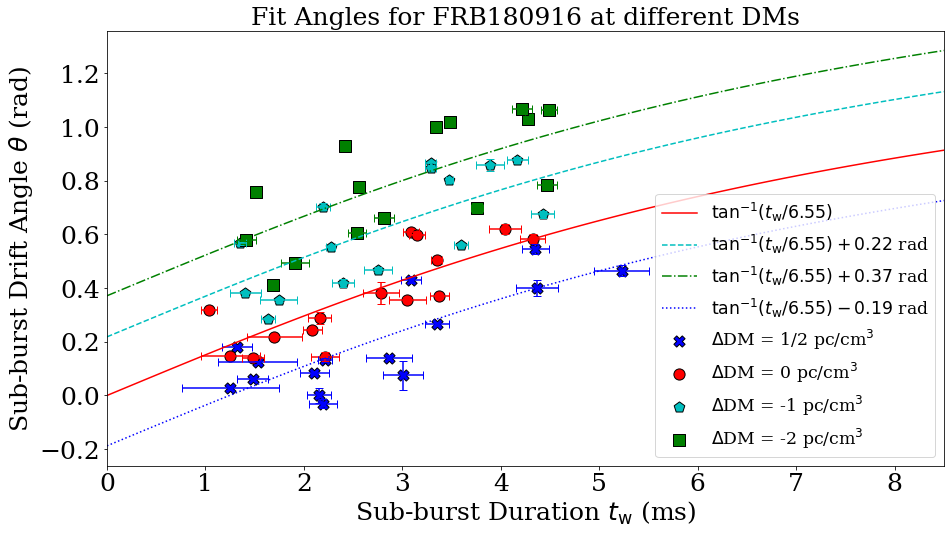

In [238]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

def cleanAngle(row):
    angle = row['angle']
    if angle < 0 or angle > np.pi:
        if angle > np.pi:
            return angle % (np.pi)
        elif angle < 0 and angle > -np.pi:
            return angle + np.pi
        elif angle < 0 and angle < -np.pi:
            angle = angle % (2*np.pi)
            if angle > np.pi:
                return angle - np.pi
            else:
                return angle
    else:
        return angle

def atanmodel(B, x):
    return np.arctan(x/B[0])

zero_ddm_fit = 6.554218399099785
def offset_atanmodel(B, x):
    return np.arctan(x/zero_ddm_fit) + B[0]

thetamodel = scipy.odr.Model(atanmodel)
offsetmodel = scipy.odr.Model(offset_atanmodel)

for dataframe180916 in dataframes180916:
    dataframe180916['drift_abs'] = abs(dataframe180916['drift (mhz/ms)'])
    dataframe180916['drift_over_nuobs'] = dataframe180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
    dataframe180916['min_sigma'] = dataframe180916[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
    dataframe180916['max_sigma'] = dataframe180916[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
    # the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
    dataframe180916['min_sigma_error'] = dataframe180916[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
    dataframe180916['max_sigma_error'] = dataframe180916[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

    dataframe180916['sigma_t']   = dataframe180916[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

    dataframe180916['tau_w'] = dataframe180916[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
        lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
        axis=1
    )

    # this error is in ms
    dataframe180916['tau_w_error'] = dataframe180916[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
        lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
        axis=1
    )

    dataframe180916['sigma_t_ms'] = dataframe180916['sigma_t']*1e3
    dataframe180916['tau_w_ms'] = dataframe180916['tau_w']*1e3

    ## Redshift corrections
    dataframe180916['drift_z'] = dataframe180916[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
    dataframe180916['tau_w_ms_z'] = dataframe180916[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)
    
    ## angle clean (0, pi)
    # dataframe180916['angle_clean'] = (np.pi/2) - dataframe180916[['angle']].apply(cleanAngle, axis=1) 
    dataframe180916['angle_clean'] = dataframe180916[['angle']].apply(cleanAngle, axis=1) - (np.pi/2)
    # dataframe180916['angle_clean'] = (3*np.pi/2) - dataframe180916[['angle']].apply(cleanAngle, axis=1) 

markersize = 125 #100
fontsize = 25 #18
annotsize = 14
logscale = False
figsize = (15, 8)
ax = dataframes180916[3].drop([15]).plot.scatter(x='tau_w_ms', y='angle_clean', 
                           xerr=dataframes180916[3]['tau_w_error'],
                           yerr=dataframes180916[3]['angle_error'],
                           figsize=figsize, s=markersize, c='b', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X', edgecolors='k',
                           label='$\Delta$DM = 1/2 pc/cm$^3$')

markers = ['o', 'p', 's']
for frame, c, label, mark in zip(dataframes180916[:3], ['r', 'c', 'g'], ['$\Delta$DM = 0 pc/cm$^3$', '$\Delta$DM = -1 pc/cm$^3$', '$\Delta$DM = -2 pc/cm$^3$'], markers):
    frame.drop([15]).plot.scatter(ax=ax, x='tau_w_ms', y='angle_clean', 
                                xerr=frame['tau_w_error'],
                                yerr=frame['angle_error'],
                                figsize=figsize, s=markersize, c=c, colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker=mark, edgecolors='k',
                                label=label)

ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
#ax.set_ylabel('-$\pi/2 + $ Gaussian2d angle (rad)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Angle $\\theta$ (rad)', size=fontsize)

## Find Fits
lstyles = ['-', '--', '-.', ':']
for dataframe180916, drops, pcol, beta, lstyle in zip(dataframes180916, [[15], [15], [15], [15]], ['r', 'c', 'g', 'b'], [-6, -4, -3, -9], lstyles):
    if dataframe180916.equals(dataframes180916[0]):        
        model = thetamodel
    else:
        model = offsetmodel
    #model = thetamodel
    
    datafitter = scipy.odr.RealData(dataframe180916.drop(drops)['tau_w_ms'], 
                                 dataframe180916.drop(drops)['angle_clean'])
    anglefitter = scipy.odr.ODR(datafitter, model, beta0=[1])
    anglefitter.set_job(fit_type=0)
    anglefit = anglefitter.run()
    
    tws = np.linspace(0, 8.5, num=80)
    print(anglefit.beta)
    #print(anglefit.beta[0])
    if model == thetamodel:
        plt.plot(tws, np.arctan(tws/anglefit.beta[0]), c=pcol, label="$\\tan^{{-1}}(t_\\mathrm{{w}}/{:.2f})$".format(anglefit.beta[0]), linestyle=lstyle)
    elif model == offsetmodel:
        plt.plot(tws, np.arctan(tws/zero_ddm_fit) + anglefit.beta[0], c=pcol, label="$\\tan^{{-1}}(t_\\mathrm{{w}}/{:.2f}) {:+.2f}$ rad".format(zero_ddm_fit, anglefit.beta[0]), linestyle=lstyle)

## Check fits assuming additionl DM produces rotation
# time_res = 0.98304 # ms
# freq_res = 6.25 # MHz
# burstbandwidth = 250 # MHz, roughly
# ddms = [1/2, -1, -2] # pc/cm^3
# DM = 348.82  # pc/cm^3
# nu_high, nu_low = 800, 400 # MHz
# for ddm in ddms:
#     deltat = 4.14937759336e6 * (nu_low**-2 - nu_high**-2) * ddm
#     dtheta = np.arctan(np.tan(dataframes180916[3]['angle_clean']) - (deltat / burstbandwidth) * (freq_res/time_res) * (ddm / DM))
    
## Point Annotations
# for k, v in dataframes180916[3].iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in dataframes180916[1].drop([15]).iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in dataframes180916[0].iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
    
ax.set_xlim(0, 8.5)
plt.title("Fit Angles for FRB180916 at different DMs", size=25)
plt.legend(fontsize='xx-large')
for fformat in ['png', 'pdf', 'eps']: plt.savefig('angleatdifferentDMs.{}'.format(fformat))

## Compute 180814 Trial DM details

In [239]:
dataframes180814[-1]

,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle,center_f,amp_error,xo_error,yo_error,sigmax_error,sigmay_error,angle_error,drift error (mhz/ms),red_chisq,time_res,z
name,,,,,,,,,,,,,,,,,,,
180814.0,5.670687,80.406045,128.324544,17.719249,4.779627,5.103253,-7.714584,5.103253,395.645547,0.036336,0.051716,0.105644,0.113564,0.030633,0.002636,0.057741,3.498729,0.000983,0.05
180911.0,5.873129,80.349086,128.167440,4.354391,-11.066782,6.502159,-14.284574,4.931362,618.678586,0.052257,0.043462,0.096515,0.038756,0.098500,0.005859,0.394686,3.426166,0.000983,0.05
180919.0,104.745424,121.681746,75.970376,749.280682,NaN,2.000000,1.454854,0.429204,519.271357,inf,inf,inf,inf,inf,inf,inf,NaN,0.000983,0.05
180917.0,16.693083,80.477140,128.467883,36.828901,-10.856063,5.508064,-1.557119,5.508064,697.280636,0.054616,0.089565,0.088023,0.120761,0.035497,0.001494,0.004653,1.012359,0.000983,0.05
180917.1,9.009060,24.447333,128.299592,12.093802,-3.691198,1.726556,-10.121922,1.726556,782.810236,0.149921,0.068247,0.199066,0.201275,0.061429,0.007921,0.523135,0.420855,0.000983,0.05
180917.2,10.883902,22.483925,128.449073,15.634604,-7.561518,1.835022,-5.874891,1.835022,692.283731,0.146219,0.112314,0.203934,0.209809,0.102394,0.012042,0.280632,0.125307,0.000983,0.05
180917.3,3.194352,32.499556,128.461706,9.577443,14.667571,6.720345,-3.401248,5.149549,623.010978,0.059524,0.198778,0.258733,0.178631,0.273286,0.030025,0.266250,0.518303,0.000983,0.05


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


25.090328186500074
38.246391902506566
42.55329671365216
23.89199995428215
32.19739983661563
22.39485261433129
20.0


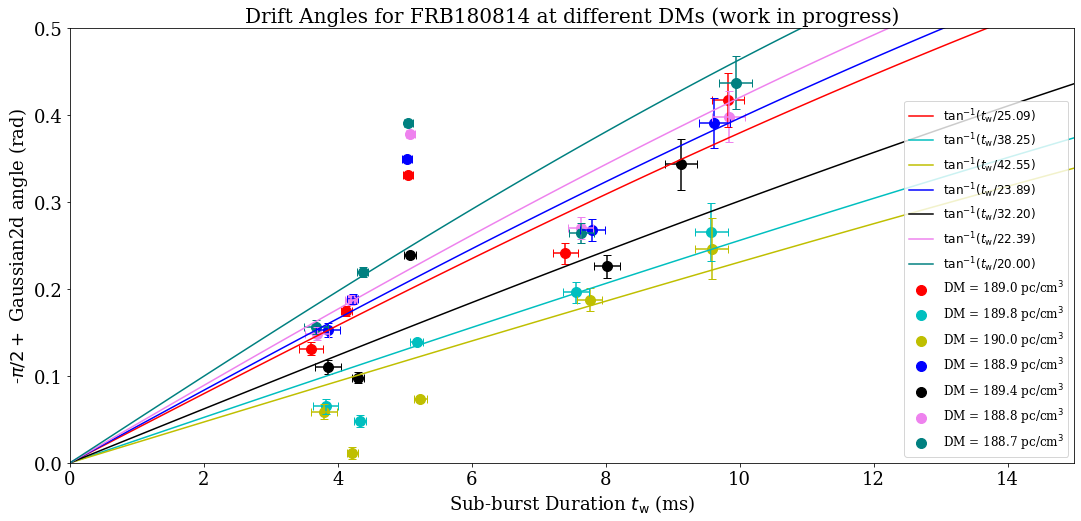

In [240]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

def cleanAngle(row):
    angle = row['angle']
    if angle < 0 or angle > np.pi:
        if angle > np.pi:
            return angle % (np.pi)
        elif angle < 0 and angle > -np.pi:
            return angle + np.pi
        elif angle < 0 and angle < -np.pi:
            angle = angle % (2*np.pi)
            if angle > np.pi:
                return angle - np.pi
            else:
                return angle
    else:
        return angle

def atanmodel(B, x):
    return np.arctan(x/B[0])

zero_ddm_fit = 32.197
def offset_atanmodel(B, x):
    return np.arctan(x/zero_ddm_fit) + B[0]

thetamodel = scipy.odr.Model(atanmodel)
offsetmodel = scipy.odr.Model(offset_atanmodel)

for dataframe180814 in dataframes180814:
    dataframe180814['drift_abs'] = abs(dataframe180814['drift (mhz/ms)'])
    dataframe180814['drift_over_nuobs'] = dataframe180814[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
    dataframe180814['min_sigma'] = dataframe180814[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
    dataframe180814['max_sigma'] = dataframe180814[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
    # the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
    dataframe180814['min_sigma_error'] = dataframe180814[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
    dataframe180814['max_sigma_error'] = dataframe180814[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

    dataframe180814['sigma_t']   = dataframe180814[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

    dataframe180814['tau_w'] = dataframe180814[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
        lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
        axis=1
    )

    # this error is in ms
    dataframe180814['tau_w_error'] = dataframe180814[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
        lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
        axis=1
    )

    dataframe180814['sigma_t_ms'] = dataframe180814['sigma_t']*1e3
    dataframe180814['tau_w_ms'] = dataframe180814['tau_w']*1e3

    ## Redshift corrections
    dataframe180814['drift_z'] = dataframe180814[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
    dataframe180814['tau_w_ms_z'] = dataframe180814[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)
    
    ## angle clean (0, pi)
    # dataframe180814['angle_clean'] = (np.pi/2) - dataframe180814[['angle']].apply(cleanAngle, axis=1) 
    dataframe180814['angle_clean'] = dataframe180814[['angle']].apply(cleanAngle, axis=1) - (np.pi/2)
    # dataframe180814['angle_clean'] = (3*np.pi/2) - dataframe180814[['angle']].apply(cleanAngle, axis=1) 

def errorexpr(frame):
#     ex = np.sqrt(frame['red_chisq'])*frame['tau_w_error']
#     ey = np.sqrt(frame['red_chisq'])*frame['angle_error']
    ex = frame['tau_w_error']
    ey = frame['angle_error']
    return ex, ey
    
markersize = 100
fontsize = 18
annotsize = 14
logscale = False
figsize = (18, 8)
###Defined Above: dms180814 = [189.0 , 189.8 , 190.0, 188.9 , 189.4, 188.8, 188.7]
drops = [[180919, 180917]]*len(dms180814)
colors = ['r', 'c', 'y', 'b', 'k', 'violet', 'teal']
ax = dataframes180814[0].drop(drops[0]).plot.scatter(x='tau_w_ms', y='angle_clean',
                                    xerr=errorexpr(dataframes180814[0])[0],
                                    yerr=errorexpr(dataframes180814[0])[1],
                                    figsize=figsize, s=markersize, c=colors[0], colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                                    label='DM = 189.0 pc/cm$^3$')

labels = ['DM = {} pc/cm$^3$'.format(d) for d in dms180814]
for i, frame, c, label in zip(range(0, len(dataframes180814[1:])), dataframes180814[1:], colors[1:], labels[1:]):
    frame.drop(drops[i+1]).plot.scatter(ax=ax, x='tau_w_ms', y='angle_clean', 
                        xerr=errorexpr(frame)[0],
                        yerr=errorexpr(frame)[1],
                        figsize=figsize, s=markersize, c=c, colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                        label=label)

ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('-$\pi/2 + $ Gaussian2d angle (rad)', size=fontsize)

## Find Fits
for dataframe180814, drop, pcol in zip(dataframes180814, drops, colors):
    if dataframe180814.equals(dataframes180814[4]):    
        model = thetamodel
    else:
        model = offsetmodel
    model = thetamodel
    
    #display(dataframe180814.drop(drop)[['tau_w_ms', 'angle_clean', 'tau_w_error', 'angle_error']])
    datafitter = scipy.odr.RealData(dataframe180814.drop(drop)['tau_w_ms'], 
                                dataframe180814.drop(drop)['angle_clean'],
                                sx=errorexpr(dataframe180814)[0],
                                sy=errorexpr(dataframe180814)[1])
    anglefitter = scipy.odr.ODR(datafitter, model, beta0=[20])
    anglefitter.set_job(fit_type=0)
    anglefit = anglefitter.run()
    
    tws = np.linspace(0, 15, num=80)
    #print(anglefit.beta[0])
    if model == thetamodel:
        print(anglefit.beta[0])
        plt.plot(tws, np.arctan(tws/anglefit.beta[0]), c=pcol, label="$\\tan^{{-1}}(t_\\mathrm{{w}}/{:.2f})$".format(anglefit.beta[0]))
    elif model == offsetmodel:
        plt.plot(tws, np.arctan(tws/zero_ddm_fit) + anglefit.beta[0], c=pcol, label="$\\tan^{{-1}}(t_\\mathrm{{w}}/{:.2f}) {:+.2f}$ rad".format(zero_ddm_fit, anglefit.beta[0]) )
    
## Point Annotations
# for k, v in dataframes180814[3].iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in dataframes180814[0].drop([15]).iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in dataframes180814[6].drop(drops[3]).iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
    
ax.set_xlim(0, 15)
ax.set_ylim(0, 0.5)
plt.title("Drift Angles for FRB180814 at different DMs (work in progress)", size=20)
plt.legend(fontsize='large', loc=4)
# plt.savefig('angleatdifferentDMs.png')
# plt.savefig('angleatdifferentDMs.pdf')

In [241]:
dataframes180814[3]

,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle,center_f,amp_error,...,min_sigma_error,max_sigma_error,sigma_t,tau_w,tau_w_error,sigma_t_ms,tau_w_ms,drift_z,tau_w_ms_z,angle_clean
name,,,,,,,,,,,,,,,,,,,,,
180814.0,5.673051,80.411949,128.332501,-4.834049,-17.333737,-24.782996,-8.715564,-26.353792,489.958611,0.037123,...,0.031639,0.113449,0.004752,0.005032,0.072102,4.752063,5.032325,0.018678,4.792691,0.349745
180911.0,6.144772,80.342854,128.263440,10.491787,-4.227841,4.900600,-16.690279,4.900600,620.782919,0.054305,...,0.037376,0.092749,0.004156,0.004218,0.083911,4.156137,4.218444,0.028230,4.017566,0.188211
180919.0,5.579820,80.355592,128.388101,6.282814,6.546999,4.000031,-2.745429,2.429235,478.179251,0.048773,...,0.054931,0.057248,0.006176,0.006321,0.054848,6.176257,6.321066,0.006028,6.020063,0.858438
180917.0,16.793095,80.478210,128.473646,36.645743,10.867191,5.500402,-1.581165,5.500402,692.192171,0.053371,...,0.034520,0.116684,0.010683,0.014516,0.045915,10.682883,14.516277,0.002399,13.825026,0.788013
180917.1,8.567560,24.444505,128.366396,12.715586,-3.871334,1.723508,-10.327210,1.723508,781.467515,0.136185,...,0.061534,0.202102,0.003806,0.003846,0.179401,3.805676,3.846267,0.013876,3.663111,0.152711
180917.2,11.066149,22.489538,128.468697,15.445502,-7.721443,1.838821,-5.787576,1.838821,694.818052,0.147498,...,0.103892,0.205601,0.007590,0.007798,0.184195,7.590487,7.798379,0.008746,7.427027,0.268025
180917.3,3.202346,32.535133,128.447261,9.369841,14.348564,0.390714,-3.858941,-1.180083,607.834234,0.057822,...,0.169270,0.259020,0.009211,0.009620,0.232987,9.210929,9.619769,0.006666,9.161685,0.390714


## Compute 180814 Details

Text(0.5, 0, 'Burst #')

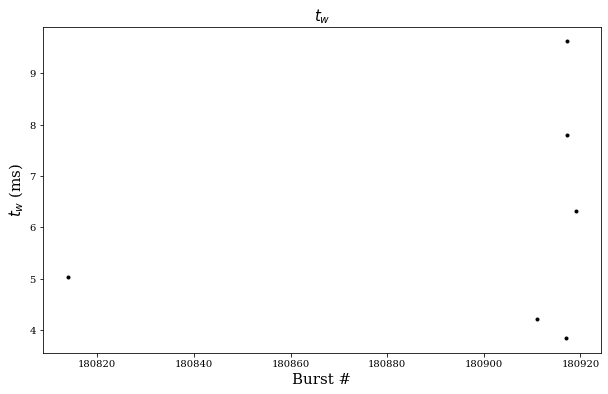

In [242]:
# bursts180814['drift_abs'] = abs(bursts180814['drift (mhz/ms)'])
bursts180814['drift_abs'] = -1*bursts180814['drift (mhz/ms)']
bursts180814['drift_over_nuobs'] = bursts180814[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts180814['min_sigma'] = bursts180814[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts180814['max_sigma'] = bursts180814[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts180814['min_sigma_error'] = bursts180814[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts180814['max_sigma_error'] = bursts180814[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts180814['sigma_t']   = bursts180814[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts180814['tau_w'] = bursts180814[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts180814['tau_w_error'] = bursts180814[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts180814['sigma_t_ms'] = bursts180814['sigma_t']*1e3
bursts180814['tau_w_ms'] = bursts180814['tau_w']*1e3

## Redshift corrections
bursts180814['drift_z'] = bursts180814[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts180814['tau_w_ms_z'] = bursts180814[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)

fontsize=15

selectbursts180814 = bursts180814.drop(180917)
ax = selectbursts180814['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ ", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')
# selectbursts180814[['tau_w_ms', 'tau_w_error']]

In [243]:
bursts180814

,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle,center_f,amp_error,...,max_sigma,min_sigma_error,max_sigma_error,sigma_t,tau_w,tau_w_error,sigma_t_ms,tau_w_ms,drift_z,tau_w_ms_z
name,,,,,,,,,,,,,,,,,,,,,
180814.0,5.673051,80.411949,128.332501,-4.834049,-17.333737,-24.782996,-8.715564,-26.353792,489.958611,0.037123,...,17.333737,0.031639,0.113449,0.004752,0.005032,0.072102,4.752063,5.032325,0.018678,4.792691
180911.0,6.144772,80.342854,128.263440,10.491787,-4.227841,4.900600,-16.690279,4.900600,620.782919,0.054305,...,10.491787,0.037376,0.092749,0.004156,0.004218,0.083911,4.156137,4.218444,0.028230,4.017566
180919.0,5.579820,80.355592,128.388101,6.282814,6.546999,4.000031,-2.745429,2.429235,478.179251,0.048773,...,6.546999,0.054931,0.057248,0.006176,0.006321,0.054848,6.176257,6.321066,0.006028,6.020063
180917.0,16.793095,80.478210,128.473646,36.645743,10.867191,5.500402,-1.581165,5.500402,692.192171,0.053371,...,36.645743,0.034520,0.116684,0.010683,0.014516,0.045915,10.682883,14.516277,0.002399,13.825026
180917.1,8.567560,24.444505,128.366396,12.715586,-3.871334,1.723508,-10.327210,1.723508,781.467515,0.136185,...,12.715586,0.061534,0.202102,0.003806,0.003846,0.179401,3.805676,3.846267,0.013876,3.663111
180917.2,11.066149,22.489538,128.468697,15.445502,-7.721443,1.838821,-5.787576,1.838821,694.818052,0.147498,...,15.445502,0.103892,0.205601,0.007590,0.007798,0.184195,7.590487,7.798379,0.008746,7.427027
180917.3,3.202346,32.535133,128.447261,9.369841,14.348564,0.390714,-3.858941,-1.180083,607.834234,0.057822,...,14.348564,0.169270,0.259020,0.009211,0.009620,0.232987,9.210929,9.619769,0.006666,9.161685


In [244]:
def reciprocal(x, a):
	return a/x

def reciprocal_log(x, b):
	return -x+b

def log_log(x, k, b):
	return k*x+b

def reciprocal_odr(B, x):
    return B[0]/x

def reciprocal_odr_log(B, x):
	return -x+B[0]

def fitreciprocal(x, data, sigma=1):
    guess = [522]
    abs_sigma = True
    if (type(sigma) == int) and (sigma == 1):
        abs_sigma = False
    sigma = np.zeros(len(data.ravel())) + sigma

    sigma = np.zeros(len(data.ravel())) + sigma
    popt, pcov = scipy.optimize.curve_fit(reciprocal, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    return popt, pcov

def fitreciprocal_log(x, data, sigma=1, loglog=False):
    guess = [522]
    abs_sigma = True
    if (type(sigma) == int) and (sigma == 1):
        abs_sigma = False
    sigma = np.zeros(len(data.ravel())) + sigma
    
    if loglog:
        guess = [1,1]
        popt, pcov = scipy.optimize.curve_fit(log_log, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    else:
        popt, pcov = scipy.optimize.curve_fit(reciprocal_log, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    return popt, pcov

fit_model = scipy.odr.Model(reciprocal_odr)
fit_model_log = scipy.odr.Model(reciprocal_odr_log)

In [245]:
# Color by source
selectbursts121102['color'] = 'r'#'c'
selectbursts121102.at[selectbursts121102.index > 'M', 'color'] = 'r'
selectbursts121102.at['C1', 'color'] = 'r'#'b'
selectbursts180916['color'] = 'b'
selectbursts180814['color'] = 'g'
michillibursts = selectbursts121102.head(18)
otherbursts = selectbursts121102.tail(6)

# selectbursts['drift error (mhz/ms)']['M8'] = 0.06448979034795*1

michillibursts['drift_z_abs'] = michillibursts[['drift_abs', 'z']].apply(lambda row: row['drift_abs']*(1+row['z'])**2, axis=1)

# Correct to the average Michilli burst frequency:
nu_obs0 = np.mean(michillibursts[['center_f']])
print(nu_obs0)
otherbursts['drift_corr'] = otherbursts[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
otherbursts['drift_err_corr'] = otherbursts[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
otherbursts['tau_w_ms_corr'] = otherbursts[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
otherbursts['tau_w_err_corr'] = otherbursts[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
otherbursts['drift_z_corr'] = otherbursts[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
otherbursts['tau_w_ms_z_corr'] = otherbursts[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

selectbursts180916['drift_corr'] = selectbursts180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180916['drift_err_corr'] = selectbursts180916[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180916['tau_w_ms_corr'] = selectbursts180916[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180916['tau_w_err_corr'] = selectbursts180916[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180916['drift_z_corr'] = selectbursts180916[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
selectbursts180916['tau_w_ms_z_corr'] = selectbursts180916[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

selectbursts180814['drift_corr'] = selectbursts180814[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180814['drift_err_corr'] = selectbursts180814[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180814['tau_w_ms_corr'] = selectbursts180814[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180814['tau_w_err_corr'] = selectbursts180814[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180814['drift_z_corr'] = selectbursts180814[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
selectbursts180814['tau_w_ms_z_corr'] = selectbursts180814[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

# print(nu_obs0)
# otherbursts[['tau_w_ms', 'tau_w_ms_corr', 'drift_abs', 'drift_corr', 'tau_w_error', 'tau_w_err_corr', 'drift error (mhz/ms)', 'drift_err_corr', 'center_f', ]]

center_f    4472.188306
dtype: float64


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

# Drift normalized by observing frequency vs. Burst Duration

[0.08219118] [0.00578131]
[0.08230166] [0.00626764]
[0.07143134] [0.00999092]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


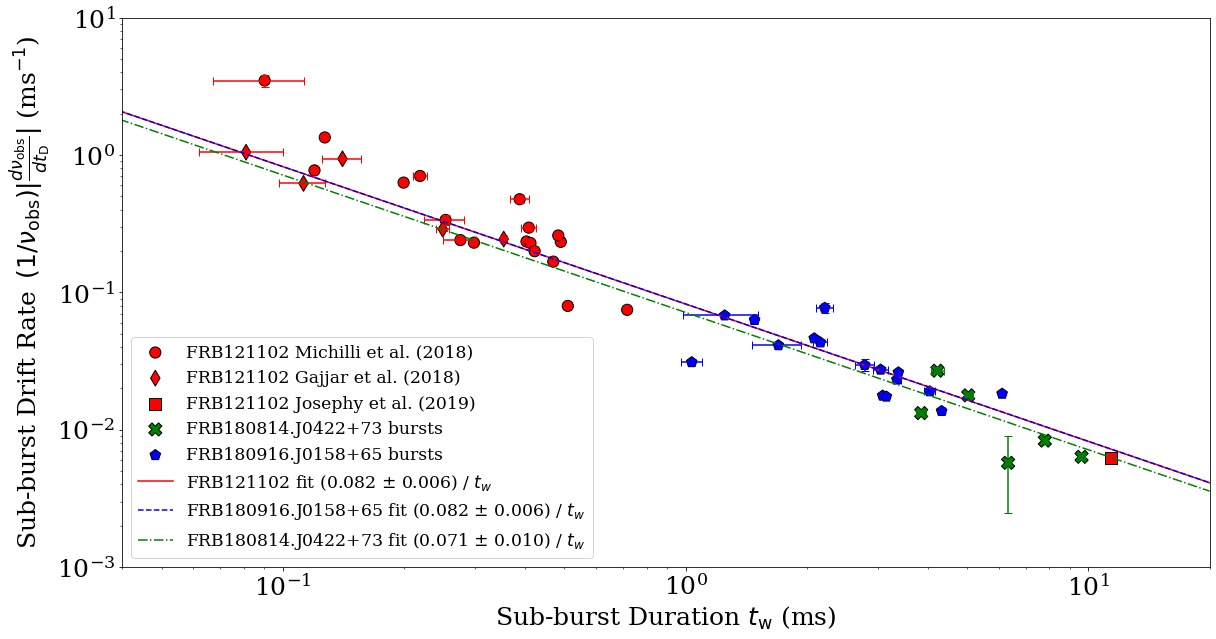

In [342]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 125#100
fontsize = 25 #18
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration' if logscale else 'drift_over_nu_obsvsduration'
figsize = (17, 8)
figsize = (17, 9)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['tau_w_error'], 
                               yerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['drift error (mhz/ms)']/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o', edgecolors='k',
                               label='FRB121102 Michilli et al. (2018)')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['tau_w_error'], 
                               yerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='FRB180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['tau_w_error'], 
                               yerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'], 
                               figsize=figsize, s=markersize+50, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X', edgecolors='k',
                               label='FRB180814.J0422+73 bursts'.format(dms180814[dm_idx]))
                               #label='FRB180814.J0422+73 bursts @ DM={} pc/cm$^3$'.format(dms180814[dm_idx]))

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['tau_w_error'], 
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], edgecolors='k',
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='FRB121102 Gajjar et al. (2018)') 
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['tau_w_error'], 
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], edgecolors='k',
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='FRB121102 Josephy et al. (2019)') 

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180814.iterrows():
#     if v['drift_over_nuobs'] > 0:
#         ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    #ax.set_xlim(0.02, 20)
    ax.set_xlim(0.04, 20)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,(1/\\nu_{\\mathrm{obs}}) \left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|$ (ms$^{-1}$)', size=fontsize)

def driftnu_error(frame):
    sx = np.log((frame['tau_w_ms'] + np.sqrt(frame['red_chisq'])*frame['tau_w_error']) / frame['tau_w_ms'])
    sy = np.log((frame['drift_over_nuobs'] + np.sqrt(frame['red_chisq'])*(frame['drift error (mhz/ms)'])) / frame['drift_over_nuobs'])
    return sx, sy

# ODR fit log
num_to_fit = 24 #23 to exlude chime
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(num_to_fit)['tau_w_ms']), 
                             np.log(selectbursts121102.head(num_to_fit)['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts121102.head(num_to_fit))[0],
                             sy=driftnu_error(selectbursts121102.head(num_to_fit))[1])
                             #sx=np.log(np.sqrt(selectbursts121102.head(num_to_fit)['red_chisq'])*selectbursts121102.head(num_to_fit)['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts121102.head(num_to_fit)['red_chisq'])*selectbursts121102.head(num_to_fit)['drift error (mhz/ms)']/selectbursts121102.head(num_to_fit)['center_f']))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms']), 
                             np.log(selectbursts180916['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts180916)[0],
                             sy=driftnu_error(selectbursts180916)[1])
                             #sx=np.log(np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

# ODR fit log 180814
fitdata_log_180814 = scipy.odr.RealData(np.log(selectbursts180814['tau_w_ms']), 
                             np.log(selectbursts180814['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts180814)[0],
                             sy=driftnu_error(selectbursts180814)[1])
                             #sx=np.log(np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'] ))
odrfitter_log180814 = scipy.odr.ODR(fitdata_log_180814, fit_model_log, beta0=[1000])
odrfitter_log180814.set_job(fit_type=0)
odrfit_log180814 = odrfitter_log180814.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta), np.exp(odrfit_log180814.beta)]
errs  = [opts[0]*(np.exp(odrfit_log.sd_beta)-1), opts[1]*(np.exp(odrfit_log180916.sd_beta)-1), opts[2]*(np.exp(odrfit_log180814.sd_beta)-1)]
#errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta), np.exp(odrfit_log180814.sd_beta)]
#names = ['Fit from FRB121102 bursts', 'Fit from FRB180916.J0158+65 bursts', 'Fit from FRB180814.J0422+73 bursts']

names = ['FRB121102 fit', 'FRB180916.J0158+65 fit', 'FRB180814.J0422+73 fit']
ls    = ['r-', 'b--', 'g-.']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    lstr = '{} ({:.3f} $\pm$ {:.3f}) / $t_w$'.format(name, opt[0], err[0])
    plt.plot(x, opt[0]/x, l, label=lstr)

handles, labels = ax.get_legend_handles_labels()
#handles = [handles[0], handles[2], handles[4], handles[5], handles[1], handles[3]]
#labels = [labels[0], labels[2], labels[4], labels[5], labels[1], labels[3]]
# handles = [handles[2], handles[5], handles[6], handles[4], handles[3], handles[0], handles[1]]
# labels = [labels[2], labels[5], labels[6], labels[4], labels[3], labels[0], labels[1]]
handles = [handles[3], handles[6], handles[7], handles[5], handles[4], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[6], labels[7], labels[5], labels[4], labels[0], labels[1], labels[2]]
plt.legend(handles, labels, fontsize='xx-large', loc=3)
# 2 digits, ytitle

# plt.title("Non Redshift Corrected", size=20)
#plt.title("FRB121102, FRB180916.J0158+65, and FRB180814.J0422+73", size=20)
plt.tight_layout()
# plt.savefig('180814_dm{}.png'.format(dms180814[dm_idx]))
# print('180814_dm{}.png'.format(dms180814[dm_idx]))
for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))
# for f in ['png']: plt.savefig('figures/{}.{}'.format(filename, f))

# Drift vs. Frequency (SM Figure)

In [95]:
selectbursts180916['center_f']

name
13.0    694.359833
14.0    513.724573
15.0    649.122617
15.5    494.136508
16.0    497.038997
18.0    622.446260
19.0    534.272500
21.0    703.912708
23.0    552.540465
24.0    536.144085
26.0    619.254770
29.0    351.018364
31.0    624.695040
32.0    624.212334
33.0    563.686814
36.0    712.519721
Name: center_f, dtype: float64

C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

[2.05817394e-08] [1.9878476e-09]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in log


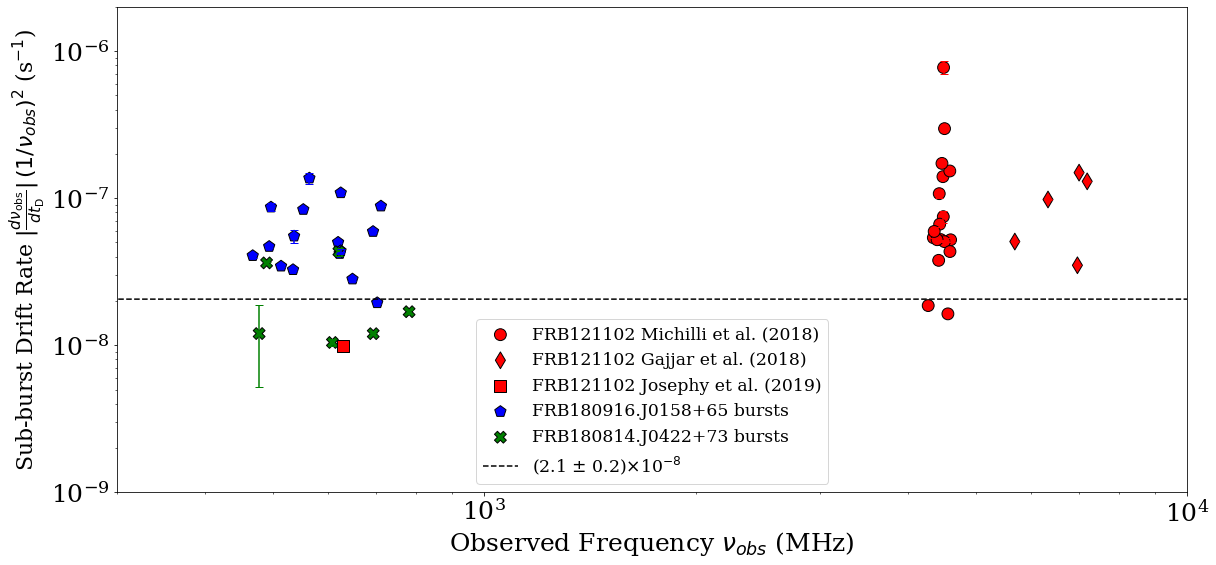

In [344]:
# michili fit
def drift_nuobs_expr(B, x):
    return B[0]*x**2

def drift_nuobs_expr_log(B, x):
    return B[0] + 2*x

def drift_nuobs_sq(B, x):
    return B[0]*np.ones(x.shape)

drift_nuobs_model = scipy.odr.Model(drift_nuobs_expr)
drift_nuobs_model_log = scipy.odr.Model(drift_nuobs_expr_log)
drift_nuobs_sq_model = scipy.odr.Model(drift_nuobs_sq)

plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 140
fontsize = 25
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration_inprep' if logscale else 'drift_over_nu_obsvsduration_inprep'
figsize = (17, 8)
# figsize = (14, 10)

michillibursts['drift_abs_z'] = michillibursts['drift_abs']*(1+michillibursts['z'])**2
michillibursts['drift_abs_nuobssq'] = michillibursts['drift_abs']*(1/michillibursts['center_f']**2)/1000
michillibursts['center_f_z'] = michillibursts['center_f']*(1+michillibursts['z'])

selectbursts180916['drift_abs_z'] = selectbursts180916['drift_abs']*(1+selectbursts180916['z'])**2
selectbursts180916['drift_abs_nuobssq'] = selectbursts180916['drift_abs']*(1/selectbursts180916['center_f']**2)/1000
selectbursts180916['center_f_z'] = selectbursts180916['center_f']*(1+selectbursts180916['z'])

selectbursts180814['drift_abs_z'] = selectbursts180814['drift_abs']*(1+selectbursts180814['z'])**2
selectbursts180814['drift_abs_nuobssq'] = selectbursts180814['drift_abs']*(1/selectbursts180814['center_f']**2)/1000
selectbursts180814['center_f_z'] = selectbursts180814['center_f']*(1+selectbursts180814['z'])

otherbursts['drift_abs_z'] = otherbursts['drift_abs']*(1+otherbursts['z'])**2
otherbursts['drift_abs_nuobssq'] = otherbursts['drift_abs']*(1/otherbursts['center_f']**2)/1000
otherbursts['center_f_z'] = otherbursts['center_f']*(1+otherbursts['z'])

ax = michillibursts.plot.scatter(x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['drift error (mhz/ms)']*(1/michillibursts['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o', edgecolors='k',
                               label='FRB121102 Michilli et al. (2018)')
    
selectbursts180916.plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']*(1/selectbursts180916['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='FRB180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']*(1/selectbursts180814['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X', edgecolors='k',
                               label='FRB180814.J0422+73 bursts'.format(dms180814[dm_idx]))

otherbursts.head(5).plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq',
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']*(1/otherbursts['center_f']**2)/1000,
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', edgecolors='k', label='FRB121102 Gajjar et al. (2018)')
otherbursts.tail(1).plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq',
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']*(1/otherbursts['center_f']**2)/1000,
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', edgecolors='k', label='FRB121102 Josephy et al. (2019)')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180814.iterrows():
#     if v['drift_abs'] > 0:
#         ax.annotate(k, (v['center_f'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

# if not logscale:
#     ax.set_xlim(-0.1, 20)
#     ax.set_ylim(-0.2, 4)
# elif logscale:
#     ax.set_xlim(0.02, 50)
#     ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Observed Frequency $\\nu_{obs}$ (MHz)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|\, (1/\\nu_{obs})^{2}$ (s$^{-1}$)', size=fontsize-3)


allbursts = pd.concat([michillibursts, otherbursts, selectbursts180916, selectbursts180814])
### LINEAR FIT
fitbitch = scipy.odr.RealData(allbursts['center_f'], 
                             allbursts['drift_abs_nuobssq'],
                             sy=np.sqrt(allbursts['red_chisq'])*allbursts['drift error (mhz/ms)']*(1/allbursts['center_f']**2)/1000)
fitter_driftnuobs = scipy.odr.ODR(fitbitch, drift_nuobs_sq_model, beta0=[0.00003])
fitter_driftnuobs.set_job(fit_type=0)
fitdriftnuobs = fitter_driftnuobs.run()

### LOG FIT
# fitbitch = scipy.odr.RealData(np.log(allbursts['center_f']), 
#                              np.log(allbursts['drift_abs']))
#                              #sy=np.log(np.sqrt(allbursts['red_chisq'])*allbursts['drift error (mhz/ms)']))
# fitter_driftnuobs = scipy.odr.ODR(fitbitch, drift_nuobs_model_log, beta0=[1000])
# fitter_driftnuobs.set_job(fit_type=0)
# fitdriftnuobs = fitter_driftnuobs.run()

### Plot fits
x = np.linspace(0, 20000, num=2000)
xlog = np.log(x)
print(fitdriftnuobs.beta, fitdriftnuobs.sd_beta)

hacklbl = '(2.1 $\pm$ 0.2)$\\times$10$^{-8}$'
lbl = '({:.1e} $\pm$ {:0.2e}) $\\nu_{{obs}}^{{2}} $'.format(fitdriftnuobs.beta[0], fitdriftnuobs.sd_beta[0])
#plt.plot(x, fitdriftnuobs.beta[0]*np.ones(x.shape), 'k--', label=hacklbl)
plt.plot(x, fitdriftnuobs.beta[0]*np.ones(x.shape), 'k--', label=hacklbl)
#plt.plot(x, fitdriftnuobs.beta[0]+2*x, l, label=str((round(fitdriftnuobs.beta[0], 6))) + ' $\\nu_{obs}^{2}$')

# plt.xlim(2*10**2, 1*10**4)
# plt.ylim(10**-1, 10**5)
# plt.xlim(0, 10000); plt.ylim(-500, 20000)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[4], handles[5], handles[2], handles[3], handles[0]]
labels = [labels[1], labels[4], labels[5], labels[2], labels[3], labels[0]]
plt.legend(handles, labels, fontsize='xx-large', loc=8)

###
plt.xlim(3*10**2, 10**4)
plt.ylim(10**-9, 2*10**-6)

# plt.title("Non Redshift Corrected", size=20)
#plt.title("FRB121102, FRB180916.J0158+65, and FRB180814.J0422+73", size=20)
plt.tight_layout()
plt.savefig('driftvsnuobs_log.pdf')

# Redshift Corrected #1

To correct for redshift we scale 
### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}} \times \nu_{obs}^{-1} \times (1+z)$ and $t_w \,/\, (1+z)$

[0.11268937] [1.10537786]
[0.08308561] [1.42894252]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


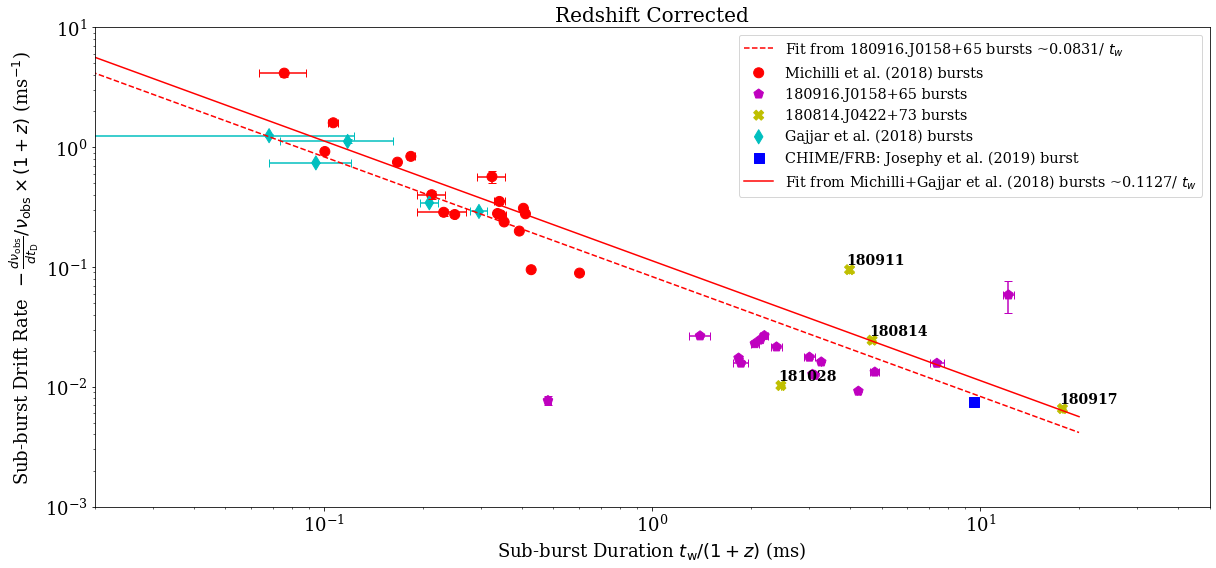

In [11]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = True
filename = 'log_drift_z_vsduration' if logscale else 'drift_z_vsduration'
figsize = (17, 8)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms_z', y='drift_z', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z']),
                               yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z'])/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_error']/(1+selectbursts180916['z']), 
                               yerr=selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']*(1+selectbursts180916['z'])/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z', 
                               xerr=selectbursts180814['red_chisq']*selectbursts180814['tau_w_error']/(1+selectbursts180814['z']), 
                               yerr=selectbursts180814['red_chisq']*selectbursts180814['drift error (mhz/ms)']*(1+selectbursts180814['z'])/selectbursts180814['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X',
                               label='180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']*(1+otherbursts['z'])/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']*(1+otherbursts['z'])/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms_z'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in selectbursts180814.iterrows():
    ax.annotate(k.split('burst')[1], (v['tau_w_ms_z'], v['drift_z']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.02, 50)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w} / (1+z)$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,-\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}} / \\nu_\\mathrm{obs} \\times (1+z)$ (ms$^{-1}$)', size=fontsize)


# ODR fit log
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(23)['tau_w_ms_z']), 
                             np.log(selectbursts121102.head(23)['drift_z']),
                             sx=np.log(selectbursts121102.head(23)['red_chisq']*selectbursts121102.head(23)['tau_w_error']/(1+selectbursts121102.head(23)['z'])), 
                             sy=np.log(selectbursts121102.head(23)['red_chisq']*selectbursts121102.head(23)['drift error (mhz/ms)']*(1+selectbursts121102.head(23)['z'])/selectbursts121102.head(23)['center_f'] ))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms_z']), 
                             np.log(selectbursts180916['drift_z']),
                             sx=np.log(selectbursts180916['red_chisq']*selectbursts180916['tau_w_error']/(1+selectbursts180916['z'])), 
                             sy=np.log(selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']*(1+selectbursts180916['z'])/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta)]
errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta)]
names = ['Fit from Michilli+Gajjar et al. (2018) bursts', 'Fit from 180916.J0158+65 bursts']
ls    = ['r-', 'r--']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    plt.plot(x, opt[0]/x, l, label=name + ' ~' + str((round(opt[0], 4))) + '/ $t_w$')

# plt.plot(x, odrfit.beta[0]/x, 'b-', label='6. x and y error \t\t${:.2f} \pm {:.2f}$'.format(odrfit.beta[0], odrfit.sd_beta[0])+'/$t_w$')

# a = np.exp(popt_log_log[1])
# k = popt_log_log[0]
# plt.plot(x, a * x**k, 'r-', label='loglog \t\t\t\t\t${:.2f}~t_w^{{{:.2f}}}$'.format(a,k))

handles, labels = ax.get_legend_handles_labels()
handles = handles [1:] + [handles[0]]
labels = labels [1:] + [labels[0]]
plt.legend(handles, labels, fontsize='x-large')

plt.title("Redshift Corrected", size=20)
plt.tight_layout()

# for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))

# Redshift Corrected #2

To correct for redshift we correct the drifts and durations to the Michilli observing frequency and then scale 
### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}} \times (1+z)^2$ and $t_w \,/\, (1+z)$

[529.81643043] [1.11078483]
[234.21800614] [1.23291917]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide


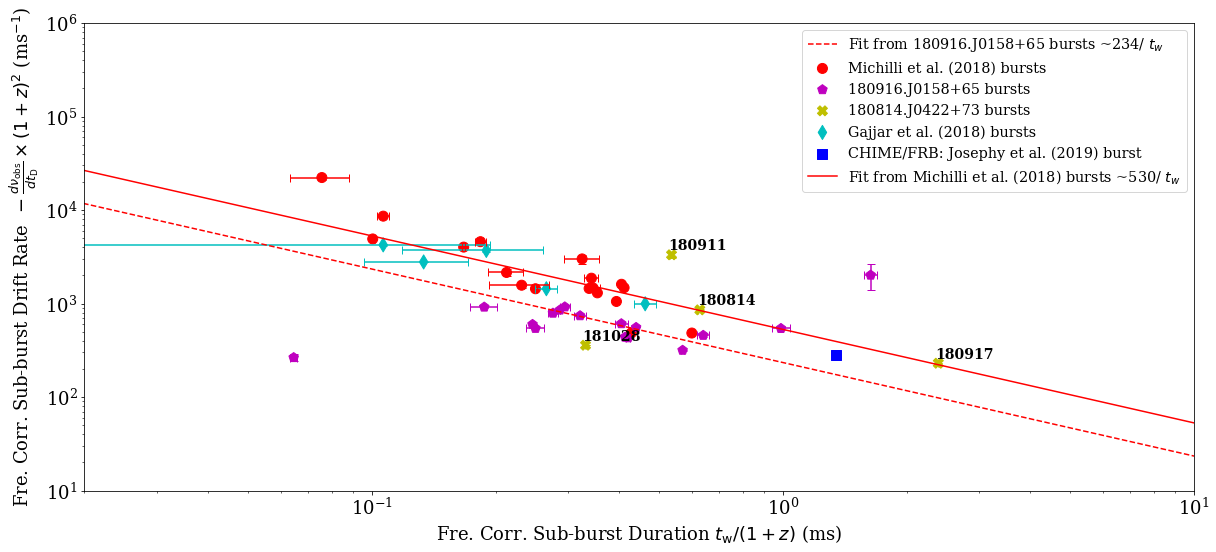

In [12]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = True
filename = 'log_drift_z_vsduration' if logscale else 'drift_z_vsduration'
figsize = (17, 8)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms_z', y='drift_z_abs', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z']),
                               yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_err_corr']/(1+selectbursts180916['z']), 
                               yerr=selectbursts180916['red_chisq']*selectbursts180916['drift_err_corr']*(1+selectbursts180916['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr', 
                               xerr=selectbursts180814['red_chisq']*selectbursts180814['tau_w_err_corr']/(1+selectbursts180814['z']), 
                               yerr=selectbursts180814['red_chisq']*selectbursts180814['drift_err_corr']*(1+selectbursts180814['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X',
                               label='180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_err_corr']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift_err_corr']*(1+otherbursts['z'])**2, 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_err_corr']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift_err_corr']*(1+otherbursts['z'])**2, 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms_z'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in selectbursts180814.iterrows():
    ax.annotate(k.split('burst')[1], (v['tau_w_ms_z_corr'], v['drift_z_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.02, 10)
    ax.set_ylim(10**1, 10**6)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Fre. Corr. Sub-burst Duration $t_\\mathrm{w} / (1+z)$ (ms)', size=fontsize)
ax.set_ylabel('Fre. Corr. Sub-burst Drift Rate $\,-\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}} \\times (1+z)^2$ (ms$^{-1}$)', size=fontsize)

# ODR fit log
fitdata_log = scipy.odr.RealData(np.log(michillibursts['tau_w_ms_z']), 
                             np.log(michillibursts['drift_z_abs']),
                             sx=np.log(michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z'])), 
                             sy=np.log(michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z']**2)))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms_z_corr']), 
                             np.log(selectbursts180916['drift_z_corr']),
                             sx=np.log(selectbursts180916['red_chisq']*selectbursts180916['tau_w_err_corr']/(1+selectbursts180916['z'])), 
                             sy=np.log(selectbursts180916['red_chisq']*selectbursts180916['drift_err_corr']*(1+selectbursts180916['z']**2)))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta)]
errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta)]
names = ['Fit from Michilli et al. (2018) bursts', 'Fit from 180916.J0158+65 bursts']
ls    = ['r-', 'r--']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    plt.plot(x, opt[0]/x, l, label=name + ' ~' + str(int(round(opt[0]))) + '/ $t_w$')

handles, labels = ax.get_legend_handles_labels()
handles = handles [1:] + [handles[0]]
labels = labels [1:] + [labels[0]]
plt.legend(handles, labels, fontsize='x-large')

plt.tight_layout()
# for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))